# Bollinger Bands Trading Strategy

## Setup

Import libs and stuff

In [3]:
import shift
import sys
import time
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import pandas as pd
import statsmodels.api as sm

pd.set_option('chained_assignment', None) # Ignore setByCopy warnings

In [14]:
# create trader object
trader = shift.Trader("nlange")
trader.connect("initiator.cfg", "47zvb6Lb")
trader.subAllOrderBook()

True

## Data

If you want fresh data (not stored in a CSV) set `fresh_data = True`

In [29]:
fresh_data = False

In [22]:
stocks = ['AAPL', 'AMZN', 'BP', 'COP', 'XOM']
if fresh_data:
    T = 200
    BS_spread = pd.DataFrame()
    for i in range(T):
        for ticker in stocks:
            bp = trader.getBestPrice(ticker)
            BS_spread = BS_spread.append(pd.DataFrame({'BidPrice':bp.getBidPrice(),'BidSize':bp.getGlobalBidSize(), 'AskPrice':bp.getAskPrice(), 
                                                        'AskSize':bp.getGlobalAskSize(), 'Last': trader.getLastPrice(ticker), 'Ticker': ticker}, index = [i]))
        time.sleep(3) 

    BS_spread.to_csv('data/stock.csv')
else:
    BS_spread = pd.read_csv("data/stock.csv", index_col=False)

In [23]:
BS_spread.head()

,BidPrice,BidSize,AskPrice,AskSize,Last,Ticker
0,221.47,6,221.50,4,221.48,AAPL
0,1829.26,6,1830.38,1,1830.00,AMZN
0,44.29,226,44.30,174,44.29,BP
0,72.60,12,72.61,4,72.61,COP
0,81.26,71,81.27,21,81.26,XOM


In [24]:
bollinger_cols = ["Upper Band", "Upper Mid", "MA", "Lower Mid", "Lower Band"]

def get_bollinger_bands(df, window):
    # Calculate 'window' Day Moving Average, Std Deviation, Upper Band and Lower Band
    df['MA'] = df['Last'].rolling(window=window, min_periods = window).mean()
    df['STD'] = df['Last'].rolling(window=window).std()
    df['Upper Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower Band'] = df['MA'] - (df['STD'] * 2)
    df['Upper Mid'] = df['MA'] + (df['STD'])
    df['Lower Mid'] = df['MA'] - (df['STD'])
    
    return df

def plot_bollinger_bands(df, ticker):
    cols = ["Last"] + bollinger_cols
    return df[cols].plot(title="Bollinger Bands for " + ticker, figsize=(12, 7))

## Trading Strategy

- **Long** When the price is in the range of [Upper Mid, Upper Band]
- **Neutral** When the price is in the range of [Lower Mid, Upper Mid]
- **Short** When the price is in the range of [Lower Mid, Lower Band]

In [25]:
def get_signal(df):
    # Define the filters for long/neutral/short
    long_fltr = (df["Upper Mid"] <= df["Last"]) & (df["Last"] <= df["Upper Band"])
    short_fltr = (df["Lower Band"] <= df["Last"]) & (df["Last"] <= df["Lower Mid"])

    # Assign a signal value to each fltr
    df["Signal"] = 0
    df.loc[long_fltr, "Signal"] = 1
    df.loc[short_fltr, "Signal"] = -1
    
    return df

In [26]:
def get_pnl(df, n_shares=100):
    # Buy/Sell 100 shares at a time
    df["signal change"] = df["Signal"].diff()
    df["position change"] = df["signal change"] * n_shares #buy/sell 100 shares at a time
    df["position"] = df["position change"].cumsum()
    df["price change"] = df["Last"].diff()
    df["PnL change"] = df["position"] * df["price change"]
    df["PnL"] = df["PnL change"].cumsum()
    
    return df


## Strategy and Portfolio Implementation

We assumes that we start with a portfolio of $1MM and divide that sum equally across all 5 stocks in our portfolio. For each stock, we calculate the bollinger bands and process those bands into a signal and then trade off that signal as follows:

- **Long** Last Price $\in$ [Upper Mid, Upper Band]
- **Neutral** Last Price $\in$ [Lower Mid, Upper Mid]
- **Short** Last Price $\in$ [Lower Mid, Lower Band]

PnL does not take into account transaction costs whch might otherwise hinder our return. Thus we suggest that this strategy should be prioritized for liquid stocks (low transaction costs).

6284.42


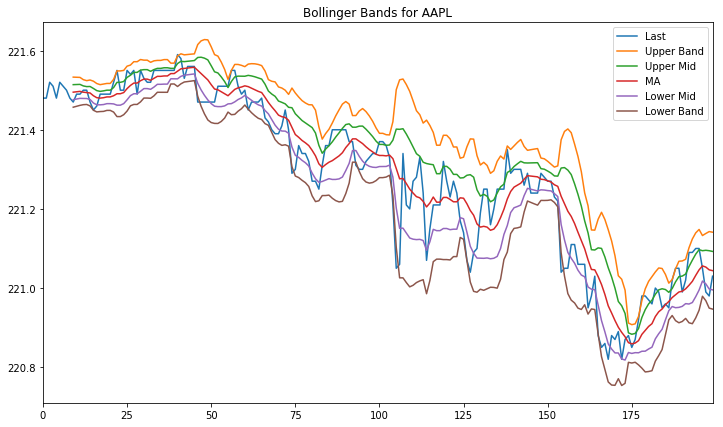

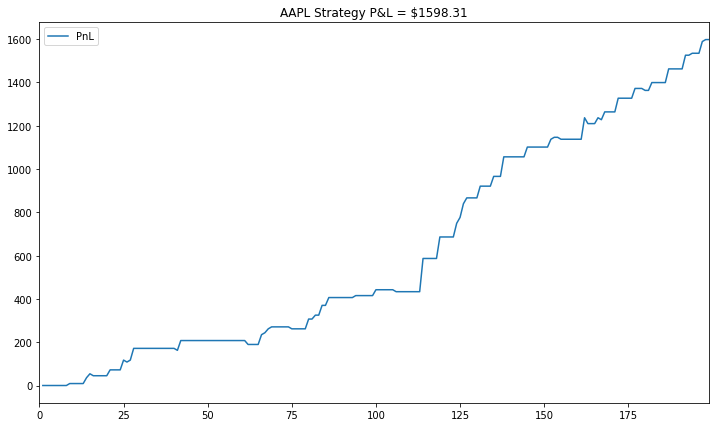

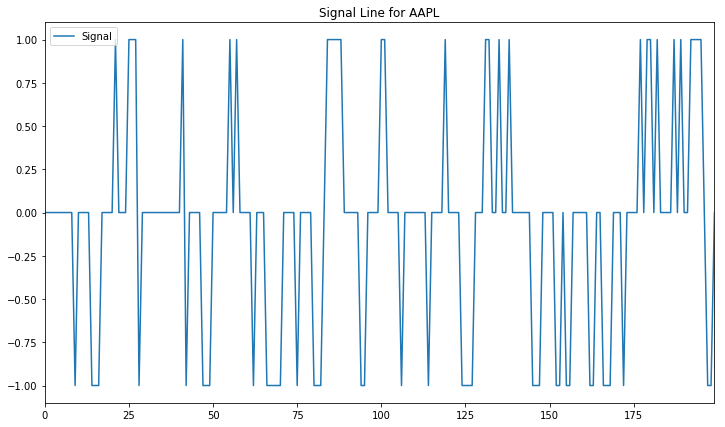

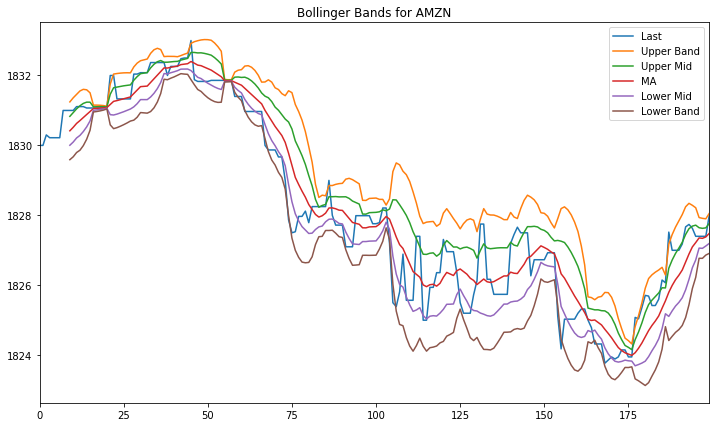

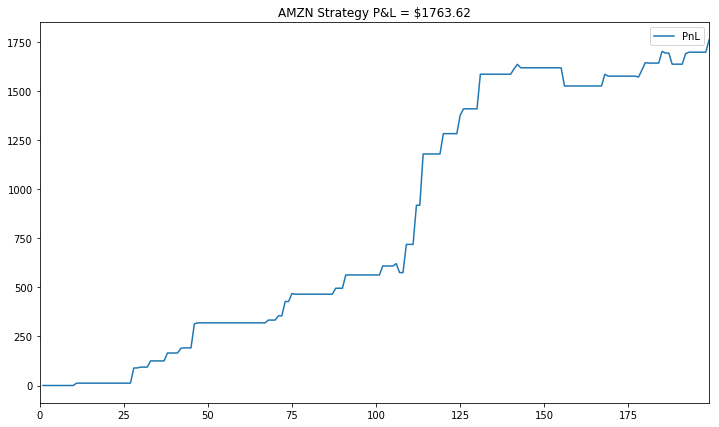

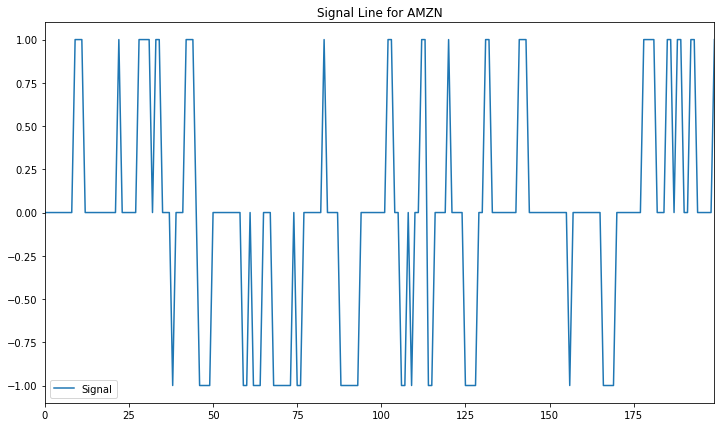

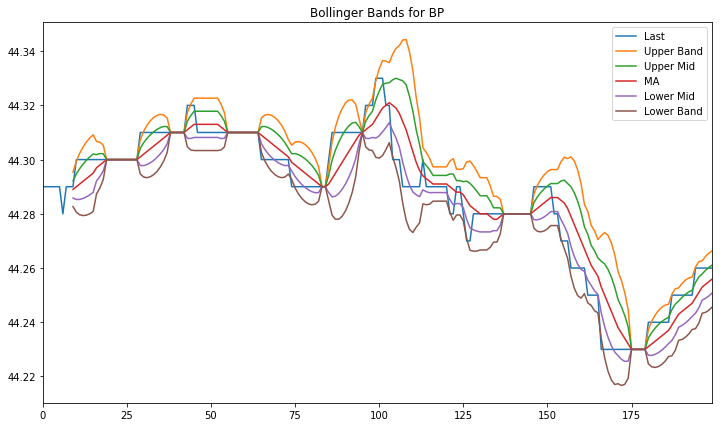

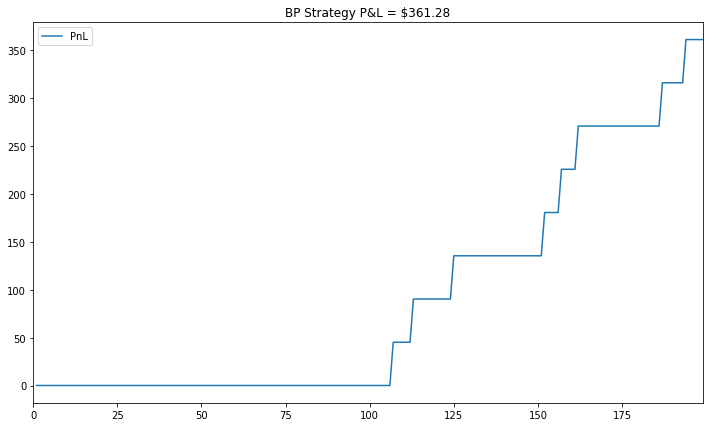

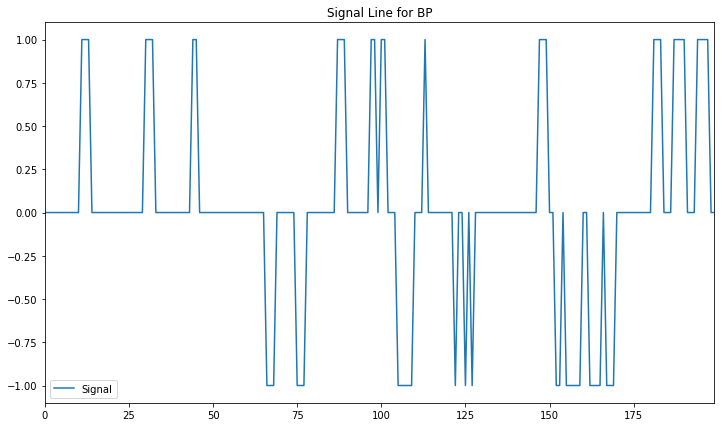

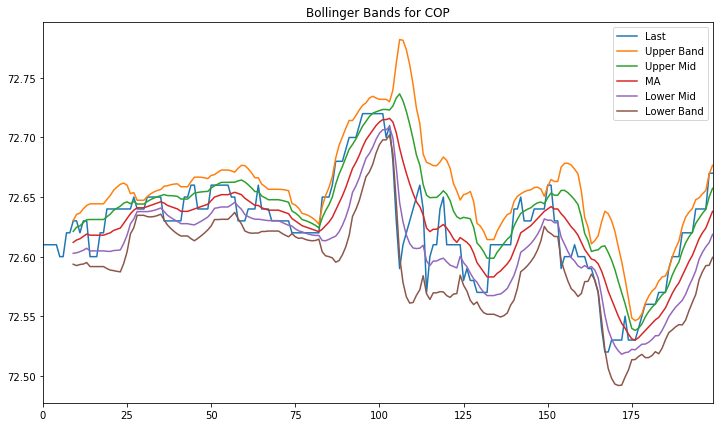

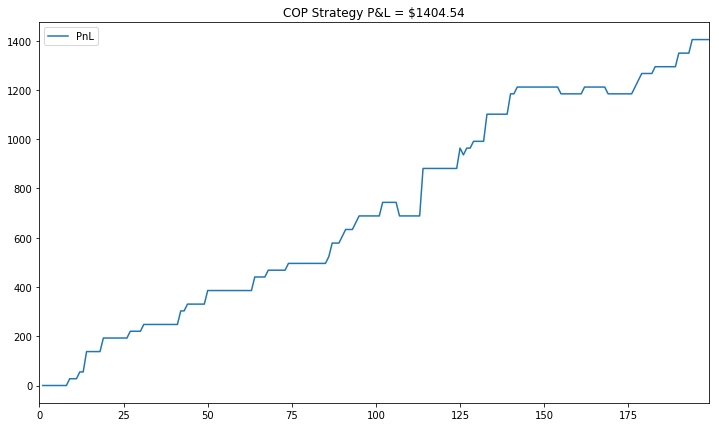

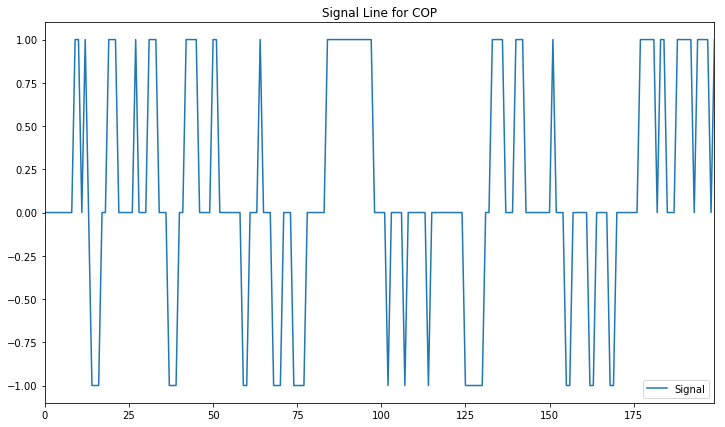

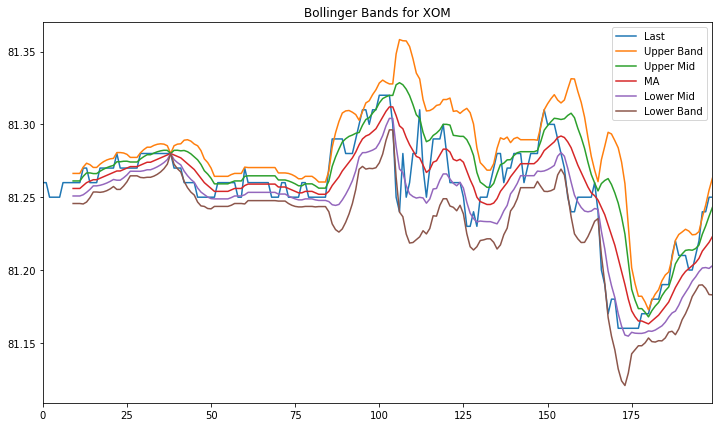

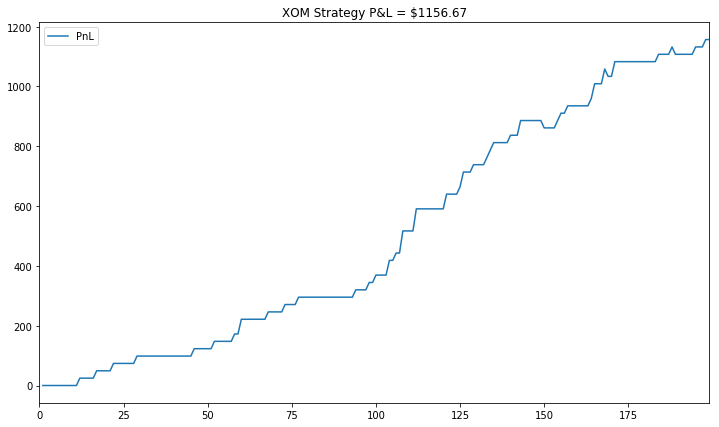

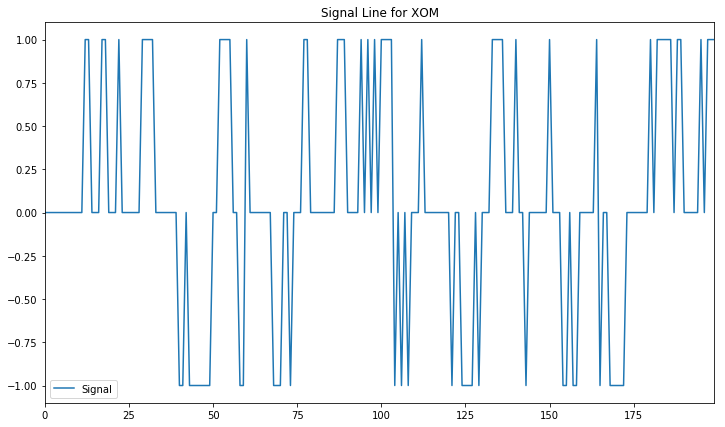

In [27]:
# Define variables to track the portfolio's P&L and portfolio value
portfolio_pnl = 0
portfolio_value = 1000000

# For each ticker
for ticker in stocks:
    # Filter the initial data to the current ticker
    fltr = BS_spread["Ticker"] == ticker
    
    # Calculate the bollinger bands for that stock with a window of 10 periods
    df = get_bollinger_bands(BS_spread[fltr], 10).reset_index()
    
    # Plot the bollinger bands
    plot_bollinger_bands(df, ticker)
    
    # Calculate the number of shares to buy/sell at a time
    n_shares = round((portfolio_value / len(stocks)) / df.loc[0, "Last"], 0)
    
    # Calculate the signal from the previously defined logic
    df = get_signal(df)
    
    # Trade based on that signal and record the point-in-time P&L
    df = get_pnl(df, n_shares)

    # Calculate the total P&L for this stock
    total_pnl = round(df.loc[df.shape[0] - 1, "PnL"], 2)

    # Add that P&L to the total portfolio
    portfolio_pnl += total_pnl
    
    # Plot that ish
    cols1 = ["PnL"]
    cols2 = ["Signal"]
    
    # visualize $$$
    ax1 = df[cols1].plot(title = ticker + " Strategy P&L = $" + str(total_pnl), figsize=(12, 7))
    ax2 = df[cols2].plot(title = "Signal Line for " + str(ticker), figsize=(12, 7))

print(portfolio_pnl)

## Strategy Return:

In [28]:
ret = (portfolio_pnl / portfolio_value) * 100
"We made: ${0} or {1}% on ${2}".format(portfolio_pnl, round(ret, 2), portfolio_value)

'We made: $6284.42 or 0.63% on $1000000'

## Scratch Work

In [120]:
bp = trader.getBestPrice("AAPL")

Stocks: AAPL, AMZN, BP, COP, XOM 

In [121]:
ticker = "AAPL"
fltr = BS_spread["Ticker"] == ticker
df = BS_spread[fltr]

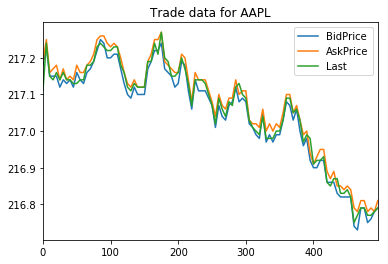

In [122]:
df[["BidPrice", "AskPrice", "Last"]].plot(title="Trade data for " + ticker)

In [123]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
df['MA'] = df['Last'].rolling(window=10, min_periods = 10).mean()
df['STD'] = df['Last'].rolling(window=10).std()
df['Upper Band'] = df['MA'] + (df['STD'] * 2)
df['Lower Band'] = df['MA'] - (df['STD'] * 2)
df['Upper Mid'] = df['MA'] + (df['STD'])
df['Lower Mid'] = df['MA'] - (df['STD'])

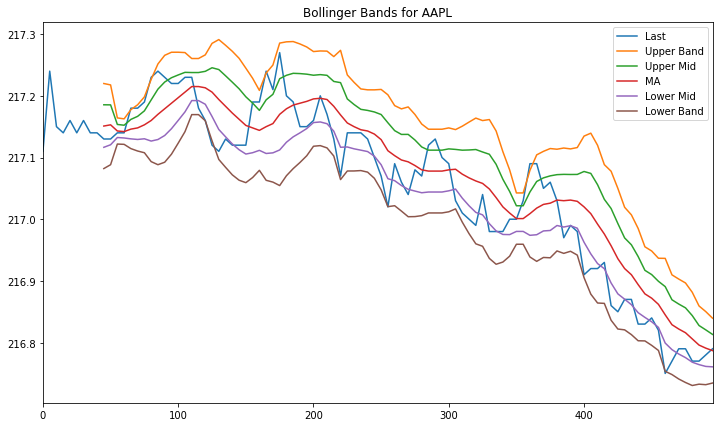

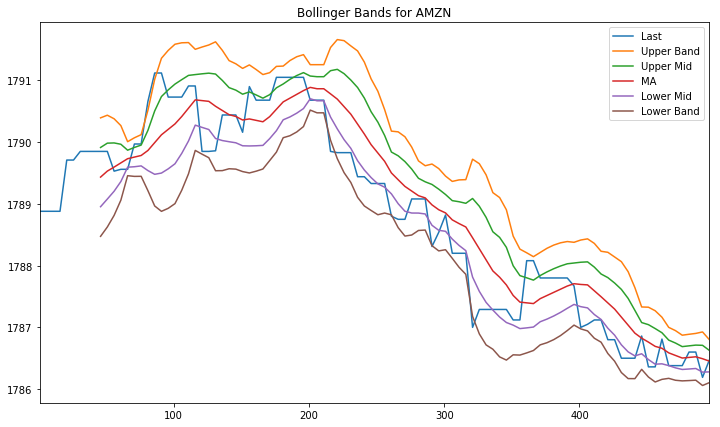

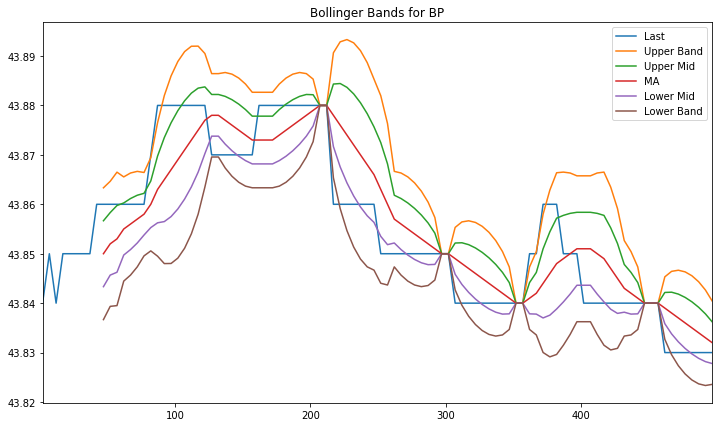

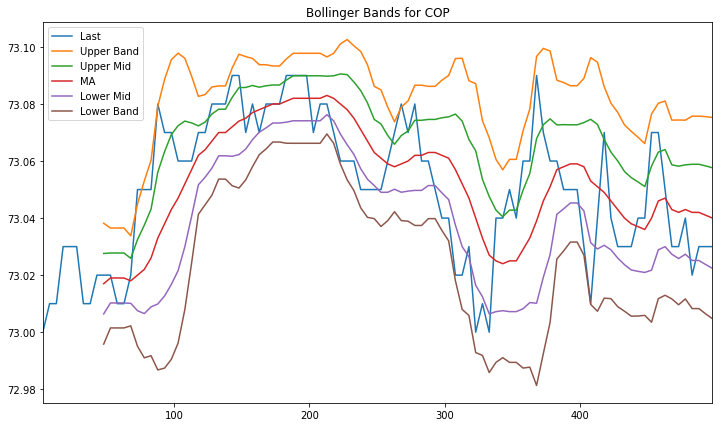

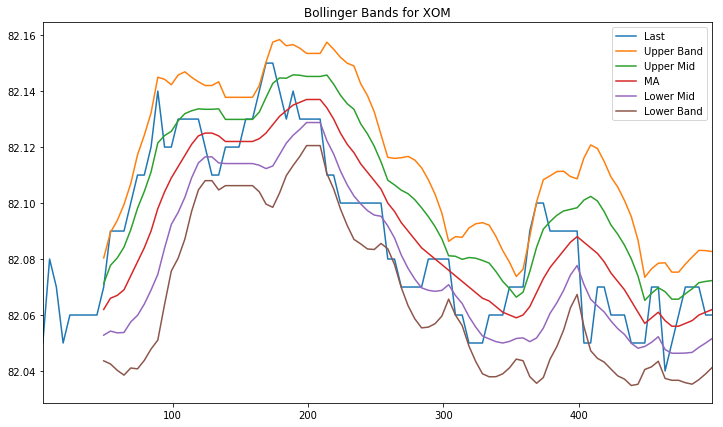

In [124]:
for ticker in stocks:
    fltr = BS_spread["Ticker"] == ticker
    df = get_bollinger_bands(BS_spread[fltr], 10)
    plot_bollinger_bands(df, ticker)

In [125]:
df_signal = get_signal(df)
df_pnl = get_pnl(df)

In [126]:
df_pnl

,BidPrice,BidSize,AskPrice,AskSize,Last,Ticker,MA,STD,Upper Band,Lower Band,Upper Mid,Lower Mid,Signal,signal change,position change,position,price change,PnL change,PnL
4,82.05,32,82.06,76,82.05,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
9,82.07,28,82.08,57,82.08,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.03,0.0,0.0
14,82.06,125,82.07,40,82.07,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,-0.01,-0.0,0.0
19,82.05,53,82.06,59,82.05,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,-0.02,-0.0,0.0
24,82.05,56,82.06,61,82.06,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.01,0.0,0.0
29,82.06,40,82.07,83,82.06,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,0.0
34,82.06,40,82.07,81,82.06,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,0.0
39,82.06,45,82.07,83,82.06,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,0.0
44,82.06,57,82.07,83,82.06,XOM,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,0.0
49,82.06,15,82.07,83,82.07,XOM,82.062,0.009189,82.080379,82.043621,82.071189,82.052811,0,0.0,0.0,0.0,0.01,0.0,0.0


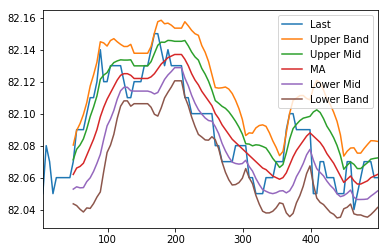

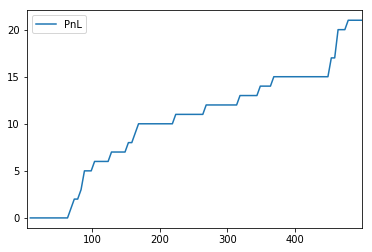

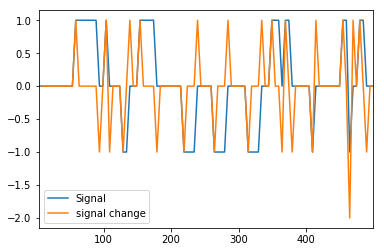

In [127]:
cols1 = ["Last"] + bollinger_cols
cols2 = ["PnL"]
cols3 = ["Signal", "signal change"]

ax1 = df_pnl[cols1].plot()
ax2 = df_pnl[cols2].plot()
ax3 = df_pnl[cols3].plot()